# Entropy production as a measure of uncertainty

here we continue the work by Nele on entropy production in convective systems as a measure for uncertainty.

In [1]:
# import necessary libraries
from scipy.integrate import odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from __future__ import division
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import itertools
import h5py
#from iapws import IAPWS97
import os,sys

In [2]:
#f = h5py.File('Perth_Sec1_bas_E0_3.h5','r')
f = h5py.File('Perth_Sec12_bas_E0_7.h5','r')
print f.keys()
temp = f['temp']
print temp.shape
vz = f['vz']
uindex = f['uindex']
print f['delz'].shape, f['delx'].shape
x = np.linspace(0,33500.,f['delx'].shape[2]+1)
z = np.linspace(-3000.,0,f['delz'].shape[0]+1)
(X,Y) = np.meshgrid(x,z)
print f['temp']

[u'comp', u'delx', u'dely', u'delz', u'df', u'ec', u'head', u'head_bcd', u'ihead_bcd', u'itemp_bcd', u'itemp_bcn', u'kx', u'ky', u'kz', u'lc', u'lx', u'ly', u'lz', u'por', u'pres', u'q', u'rc', u'rhof', u'satn', u'temp', u'temp_bcd', u'temp_bcn', u'uindex', u'visf', u'vx', u'vy', u'vz', u'x', u'y', u'z']
(60, 1, 335)
(60, 1, 1) (1, 1, 335)
<HDF5 dataset "temp": shape (60, 1, 335), type "<f8">


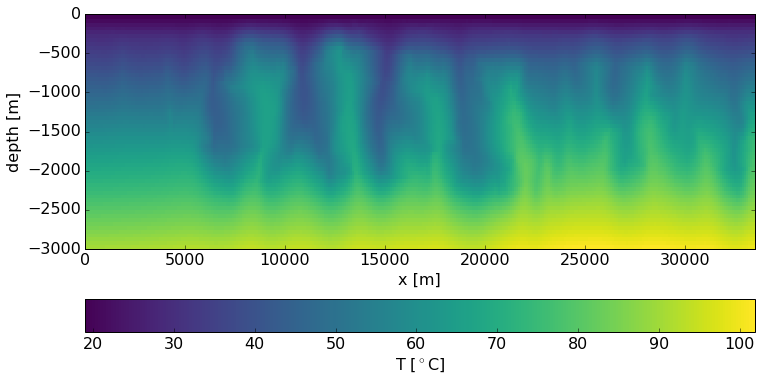

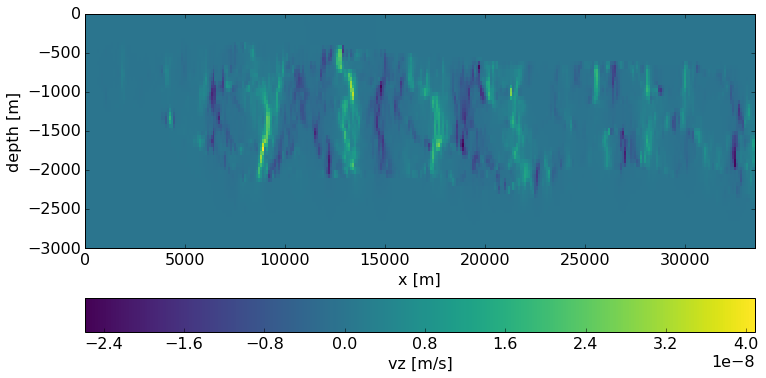

In [3]:
fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,temp[:,0,:],cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('T [$^\circ$C]',fontsize=16)
plt.savefig("eps_figs/sec12_temperature.eps",fmt='eps',dpi=800)
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,vz[:,0,:],cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('vz [m/s]',fontsize=16)
plt.savefig("eps_figs/sec12_velocity.eps",fmt='eps',dpi=800)

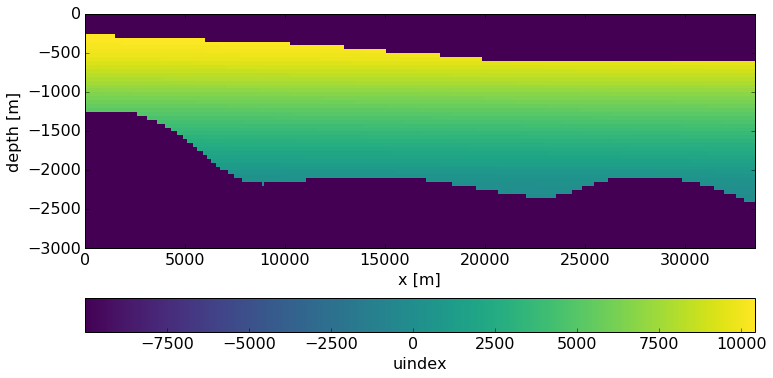

In [4]:
ui = np.array(uindex[:,0,:],dtype=float)
ui[ui < 8] = -9999


fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,ui,cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)

cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('uindex',fontsize=16)
plt.savefig("eps_figs/sec12_uindex.eps",fmt='eps',dpi=800)

In [5]:
delx = f['delx'][0,0,0]
dely = f['dely'][0,0,0]
delz = f['delz'][0,0,0]
TC = f['lz'][0,0,0]
#np.shape(temp[:,0,:])
grTx,grTz = np.gradient(temp[:,0,:])

In [6]:
grTx = grTx/delx
grTz = grTz/delz
T = temp[:,0,:]
ds = (TC/(T*T))*(grTx**2 + grTz**2)

In [7]:
print np.shape(ds)

(60, 335)


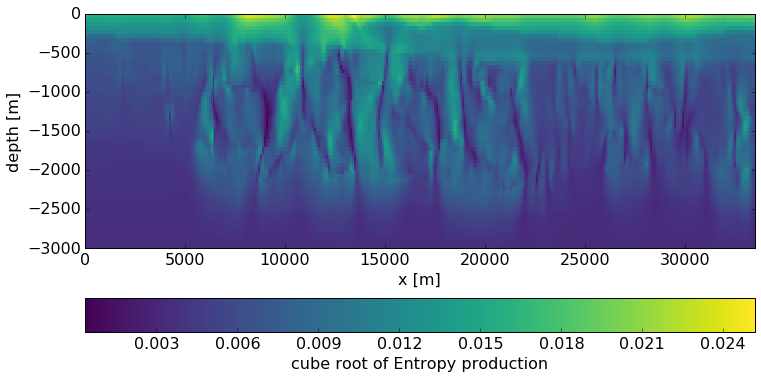

In [8]:
fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,ds**(1./3.),cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)

cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("eps_figs/sec12_entr_prod.eps",fmt='eps',dpi=800)

One main question is: How meaningful is the entropy production for the whole model? Don't we have to take it for the convecting layer only? And if, how do we do that, as the gradient-vector lengths in the dimensions will be different due to the reservoir structure.

In [9]:
def calc_ent_prod(datafile,sc,dim):
    """calculate entropy production in 2D and 3D of a whole model space. """
    f = h5py.File(datafile,'r')
    
    if dim == '3D':
        
        x = np.linspace(min(f['x'][0,0,:]),max(f['x'][0,0,:]),f['delx'].shape[2])
        y = np.linspace(min(f['y'][0,:,0]),max(f['y'][0,:,0]),f['dely'].shape[1])
        z = np.linspace(min(f['z'][:,0,0])+25,max(f['z'][:,0,0])+25,f['delz'].shape[0])
        #z1 = np.linspace(-3000.,0,fid['delz'].shape[0])
        (X,Y) = np.meshgrid(x,y)
        Z = f['z'][:,0,0]
        
        delx = f['delx'][0,0,0]
        dely = f['dely'][0,0,0]
        delz = f['delz'][0,0,0]
        
        TC = f['lz'][:,:,:]
        temp = f['temp'][:,:,:]
        uind = f['uindex'][:,:,:]
        
        grTx,grTy,grTz = np.gradient(temp)
        grTx = grTx/delx
        grTy = grTy/dely
        grTz = grTz/delz
        
        ds = (TC/temp**2)*(grTx**2 + grTy**2 + grTz**2)
        cubeds = ds**(1./3.)
        return ds,X,Y,Z,cubeds,temp,uind
    
    # if 2D, check if xz or yz
    if dim == '2D':
        dimcheck = f['temp'].shape
        #print "Shape is:", dimcheck
        if dimcheck[0] == 1 and dimcheck[1] != 1 and dimcheck[2] != 1:
            print "section is yz"
             # dimenstions
            delx = f['delx'][0,0,0]
            dely = f['dely'][0,0,0]
            delz = f['delz'][0,0,0]
    
            # Parameters: TC = Thermal conductivity, temp = temperature 
    
            TC = f['lz'][0,:,:]
            temp = f['temp'][0,:,:]
            
            grTx,grTz = np.gradient(temp)

            grTx = grTx/delx
            grTz = grTz/delz
    
            ds = (TC/(temp*temp))*(grTx**2 + grTz**2)
            cubeds = ds**(1./3.)
            return ds,cubeds
        elif dimcheck[1] == 1 and dimcheck[0] != 1 and dimcheck[2] != 1:
            #print "section is xz"
             # dimenstions
            delx = f['delx'][0,0,0]
            dely = f['dely'][0,0,0]
            delz = f['delz'][0,0,0]
    
            # Parameters: TC = Thermal conductivity, temp = temperature 
    
            TC = f['lz'][:,0,:]
            temp = f['temp'][:,0,:]
            #np.shape(temp[:,0,:])
            grTx,grTz = np.gradient(temp)

            grTx = grTx/delx
            grTz = grTz/delz
    
            ds = (TC/(temp*temp))*(grTx**2 + grTz**2)
            cubeds = ds**(1./3.)
            return cubeds
        elif dimcheck[2] == 1 and dimcheck[0] != 1 and dimcheck[1] != 1:
            print "section is xy"
             # dimenstions
            delx = f['delx'][0,0,0]
            dely = f['dely'][0,0,0]
            delz = f['delz'][0,0,0]
    
            # Parameters: TC = Thermal conductivity, temp = temperature 
    
            TC = f['lz'][:,:,0]
            temp = f['temp'][:,:,0]
            
            grTx,grTz = np.gradient(temp)

            grTx = grTx/delx
            grTz = grTz/delz
    
            ds = (TC/(temp*temp))*(grTx**2 + grTz**2)
            cubeds = ds**(1./3.)
            return ds,cubeds

In [10]:
h5test = calc_ent_prod('Perth_Sec12_bas_E0_7.h5','het','2D')

ValueError: need more than 1 value to unpack

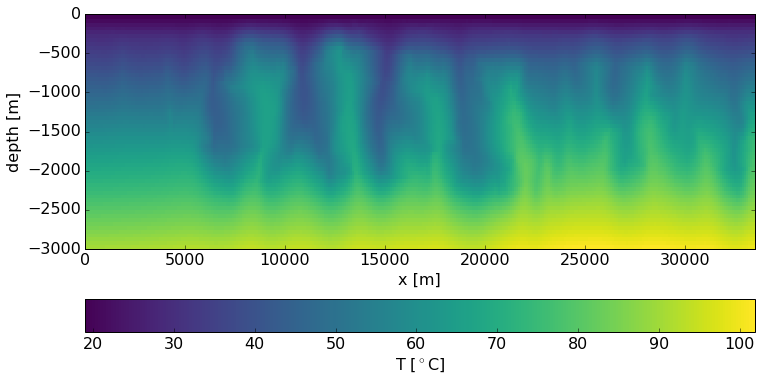

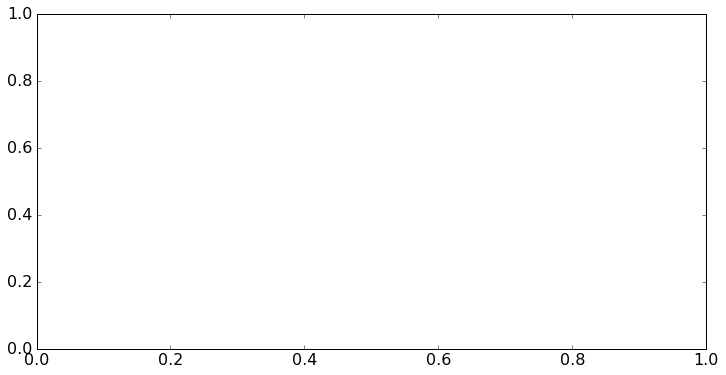

In [12]:
fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,temp[:,0,:],cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('T [$^\circ$C]',fontsize=16)

fig = plt.figure(figsize=(12,6))
cs = plt.pcolor(X,Y,h5test[1],cmap='viridis')
plt.xlim([0, 33500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)

cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('cube root of Entropy production [W m$^{-3}$ K$^{-1}$]',fontsize=16)

In [ ]:
meands = np.mean(ds)
print meands

In [ ]:
os.chdir(r'/home/jni/git/entr_att_data/ensemble/')
stuff = []
for fn in os.listdir('.'):
    #print fn
    h5file = calc_ent_prod(str(fn),'het','2D')
    #print np.shape(stuff)
    stuff.append(h5file)
os.chdir('../')

In [ ]:
print np.shape(stuff)

In [ ]:
fid = h5py.File('./ensemble/001.h5')
print fid.keys()
print fid['delx'].shape
print fid['dely'].shape
print fid['delz'].shape

x1 = np.linspace(0,33500.,fid['delx'].shape[2])
z1 = np.linspace(-3000.,0,fid['delz'].shape[0])
(X1,Y1) = np.meshgrid(x1,z1)
print stuff[0].shape, np.shape((X1))

In [ ]:
os.chdir('/home/jni/git/entropy_attractor/')
fig = plt.figure(figsize=(10,4))
cs = plt.pcolor(X1,Y1,stuff[1],cmap='viridis',vmin=0,vmax=0.034)
plt.xlim([0, 32500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='horizontal',pad=.2)
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("eps_figs/sec12_entr_prod_het1.eps",fmt='eps',dpi=800)

fig = plt.figure(figsize=(10,4))
cs = plt.pcolor(X1,Y1,stuff[3],cmap='viridis',vmin=0,vmax=0.034)
plt.xlim([0, 32500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='horizontal',pad=.2)
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("eps_figs/sec12_entr_prod_het2.eps",fmt='eps',dpi=800)

fig = plt.figure(figsize=(10,4))
cs = plt.pcolor(X1,Y1,stuff[4],cmap='viridis',vmin=0,vmax=0.034)
plt.xlim([0, 32500])
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth [m]',fontsize=16)

cbar = plt.colorbar(cs,orientation='horizontal',pad=.2)
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("eps_figs/sec12_entr_prod_het3.eps",fmt='eps',dpi=800)

In [ ]:
os.getcwd()

In [ ]:
m_ds = []
for i in range(len(stuff)):
    l = np.mean(stuff[i])
    m_ds.append(l)

In [ ]:
#m_ds.append(meands)
fig = plt.figure(figsize=(10,4))
#plt.plot(m_ds,'o',color='#33ADAD')
#plt.ylabel('cube root entropy production')
#plt.xlabel('# of realisations')
#plt.savefig("eps_figs/sec12_scatter.eps",fmt='eps',dpi=800)
plt.hist(m_ds,bins=10,color='#33ADAD',histtype='stepfilled')
plt.xlabel('cube root of entropy production')
plt.ylabel('amount of samples')
plt.savefig("eps_figs/sec12_hist.eps",fmt='eps',dpi=800)

In [ ]:
os.chdir('/home/jni/git/entr_att_data/h5s/')
stuff3D = []
dicfil = {}
tfil = {}
for fn in os.listdir('.'):
    print fn
    if fn[-1] == '5':
        ds,X,Y,Z,cubeds,tempi,uind = calc_ent_prod(str(fn),'het','3D')
        stuff3D.append(cubeds)
        dicfil[fn] = cubeds
        tfil[fn] = tempi
        print np.shape(stuff3D)
uind = h5py.File('Perth_Basin_input_final.h5')['uindex'][:,:,:]
os.chdir('../')

In [ ]:
print dicfil.keys()

In [ ]:
print X.shape, Y.shape, np.shape(stuff3D[1][42,:,:])

In [ ]:
os.chdir("/home/jni/git/entropy_attractor/eps_figs/")
fig = plt.figure(figsize=(7,14))
cs = plt.pcolor(X,Y,dicfil['Perth_Basin_input_E0_1.h5'][50,:,:],cmap='viridis',vmin=0,vmax=0.034)
#plt.xlim([0, 32500])
plt.xlabel('x[m]',fontsize=16)
plt.ylabel('y[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("3D_het1.eps",fmt='eps',dpi=800)

fig = plt.figure(figsize=(7,14))
cs = plt.pcolor(X,Y,dicfil['Perth_Basin_input_final.h5'][50,:,:],cmap='viridis',vmin=0,vmax=0.034)
#plt.xlim([0, 32500])
plt.xlabel('x[m]',fontsize=16)
plt.ylabel('y[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("3D_hom.eps",fmt='eps',dpi=800)

fig = plt.figure(figsize=(7,14))
cs = plt.pcolor(X,Y,dicfil['Perth_Basin_input_final_comp.h5'][50,:,:],cmap='viridis',vmin=0,vmax=0.034)
#plt.xlim([0, 32500])
plt.xlabel('x[m]',fontsize=16)
plt.ylabel('y[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('cube root of Entropy production',fontsize=16)
plt.savefig("3D_comp.eps",fmt='eps',dpi=800)

font = {'size'   : 16}

matplotlib.rc('font', **font)

In [ ]:
mds_3d = []
for i in range(len(stuff3D)):
    l = np.mean(stuff3D[i])
    mds_3d.append(l)

In [ ]:
print(np.mean(dicfil['Perth_Basin_input_final_comp.h5']))
print(np.mean(dicfil['Perth_Basin_input_E0_1.h5']))
print(np.mean(dicfil['Perth_Basin_input_final.h5']))

In [ ]:
print(mds_3d)
os.chdir("/home/jni/git/entropy_attractor/eps_figs/")

In [ ]:
md3d_het = mds_3d[:2] + mds_3d[3:5] + mds_3d[6:]
md3d_comp = mds_3d[5]
md3d_hom = mds_3d[2]
md3d_plot = np.array([np.mean(md3d_het) , md3d_hom ,md3d_comp])
xax = np.array([1, 2, 3])

labels = ['heterogeneous','homogeneous','compaction']

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(xax,md3d_plot,'o',markersize=13,color='#33ADAD')
ax.margins(0.2)
ax.set_ylim([5e-3,6.5e-3])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.set_xticklabels(labels)
#ax.semilogy()

T=np.arange(len(xax))+1.
ax.set_xticks(T)
ax.set_ylabel('Entropy production')

font = {'size'   : 18}

matplotlib.rc('font', **font)
plt.savefig("3D_comparison.eps",fmt='eps',dpi=800)
print mds_3d

In [ ]:
print "Ratio compactio/other","Ratio homogeneous/other"
for i in mds_3d:
    print mds_3d[5]/i, [], mds_3d[2]/i

## Paper / extended Abstract outline:

* Introduction  
* Theory and Methods used  
    * Explain attractors  
    * Explain entropy attractors
* Geological Model Perth - complexity of convection are the results meaningful in terms of model convergence?  
* Results:  
    * Attractors, local attractors of change in enthalpy, change in velocity, differences in homogeneous to heterogeneous model  
    * Entropy Production show that entropy production can indicate complexity and uncertainty of a model. Show Section 1 that shows high entropy production in shallow aquifer, way higher than entropy production in homogeneous model  
* Discussion:  
    * Discuss especially how useful the indicators such as attractors and entr. production are to have a meaningfuls assessment of model quality  
* Conclusion


In [ ]:
os.chdir("/home/jni/git/entropy_attractor/eps_figs/")
cc = 1
f, axarr = plt.subplots(4, sharex=True, figsize=[15,20])
al=axarr[0].pcolor(X[0,:],Z-4500,tfil['Perth_Basin_input_final.h5'][:,cc,:],cmap='Oranges',vmin=10,vmax=110)
axarr[0].set_title('EW cross section')
axarr[1].pcolor(X[0,:],Z-4500,tfil['Perth_Basin_input_final_comp.h5'][:,cc,:],cmap='Oranges',vmin=10,vmax=110)
axarr[2].pcolor(X[0,:],Z-4500,tfil['Perth_Basin_input_E0_1.h5'][:,cc,:],cmap='Oranges',vmin=10,vmax=110)
axarr[3].pcolor(X[0,:],Z-4500,uind[:,cc,:],cmap='Oranges')
axarr[3].set_xlabel('X [m]',fontsize=24)
axarr[1].set_ylabel('depth [m]', fontsize=24)
#cbar = plt.colorbar(al,orientation='horizontal',norm=matplotlib.colors.Normalize(vmin=10, vmax=110))
#cbar.set_label('Temperature [$^\circ$C]',fontsize=16)
#plt.savefig("EW_CS_uindex_oranges_pcolor.png",fmt='png',dpi=800)

In [ ]:
cc = 62
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=([20,10]))
axs[0,0].contourf(X[0,:],Z-4500,uind[:,cc,:],cmap='gray')
axs[0,1].contourf(X[0,:],Z-4500,tfil['Perth_Basin_input_final.h5'][:,cc,:],15,cmap='Oranges',vmin=10,vmax=110)
axs[0,1].contour(X[0,:],Z-4500,uind[:,cc,:],cmap='gray')
#fig.title('EW cross section')
axs[1,0].contourf(X[0,:],Z-4500,tfil['Perth_Basin_input_final_comp.h5'][:,cc,:],15,cmap='Oranges',vmin=10,vmax=110)
axs[1,0].contour(X[0,:],Z-4500,uind[:,cc,:],cmap='gray')
al=axs[1,1].contourf(X[0,:],Z-4500,tfil['Perth_Basin_input_E0_1.h5'][:,cc,:],15,cmap='Oranges',vmin=10,vmax=110)
axs[1,1].contour(X[0,:],Z-4500,uind[:,cc,:],cmap='gray')
font = {'size'   : 24}
matplotlib.rc('font', **font)
axs[0,0].set_ylabel('depth [m]')
axs[1,0].set_ylabel('depth [m]')
axs[1,0].set_xlabel('x [m]')
axs[1,1].set_xlabel('x [m]')
fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([1.0, 0.15, 0.03, 0.7])
cbar = fig.colorbar(al, cax=cbar_ax)
#cbar = plt.colorbar(al,orientation='horizontal',norm=matplotlib.colors.Normalize(vmin=10, vmax=110))
cbar.set_label('Temperature [$^\circ$C]')
fig.tight_layout()
plt.savefig("EW_CS_uindex_oranges_pcolor_tight_legend_rev_gray.eps",fmt='eps',dpi=600, 
            bbox_extra_artists=(cbar_ax,), bbox_inches='tight')

In [ ]:
print(Z[82]-4500)
fig = plt.figure(figsize=(7,14))
cs = plt.pcolor(X,Y,uind[82,:,:],cmap='seismic')
#plt.xlim([0, 32500])
plt.xlabel('x[m]',fontsize=16)
plt.ylabel('y[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('uindex',fontsize=16)

In [ ]:
os.chdir('/home/jni/git/entr_att_data/h5s/')
cl_b = h5py.File('Pb_bcd_closed_new_h.h5')
op_b = h5py.File('Pb_bcd_north_open.h5')
comp_cl = h5py.File('Perth_Basin_input_final_comp.h5')
het_cl = h5py.File('Perth_Basin_input_E0_4.h5')
os.chdir('../')

In [ ]:
Tdat = np.loadtxt('Temp_data_monitoring_wells.csv',delimiter=',',usecols=[2,5,6,7,8],skiprows=1)

In [ ]:
cl_x = cl_b['x'][0,0,:]
cl_y = cl_b['y'][0,:,0]
cl_z = cl_b['z'][:,0,0]

In [ ]:
fig = plt.figure(figsize=(4,8))
plt.scatter(Tdat[47:57,0],Tdat[47:57,1])
plt.plot(cl_b['temp'][:,68,60],cl_z-4500,'-',color='#33AADD')
plt.plot(comp_cl['temp'][:,68,60],cl_z-4500,'-',color='#992222')
plt.plot(het_cl['temp'][:,68,60],cl_z-4500,'-',color='#229922')
plt.ylim([-600, 50])
plt.xlim([0, 60])

In [ ]:
os.chdir("/home/jni/git/entropy_attractor/eps_figs/")
cc = 199
font = {'size'   : 14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=([10,5]))
cs = plt.pcolor(X[0,:],Z-4500,cl_b['vy'][:,cc,:],cmap='viridis',vmin=-1e-9,vmax=1e-9)
plt.xlabel('x [m]')
plt.ylabel('depth [m]')
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label('v$_y$ [m s$^{-1}$]')
fig.tight_layout()
plt.savefig("EW_northernclosed.png",fmt='png',dpi=600)
fig = plt.figure(figsize=([10,5]))
cs = plt.pcolor(X[0,:],Z-4500,op_b['vy'][:,cc,:],cmap='viridis',vmin=-3e-8,vmax=3e-8)
plt.xlabel('x [m]')
plt.ylabel('depth [m]')
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label('v$_y$ [m s$^{-1}$]')
fig.tight_layout()
plt.savefig("EW_northernopen.png",fmt='png',dpi=600)